# Filtering a noisy speech signal

**Topics**
* Intro to wiener filters

**Learning goals**
* Familiarity with calculating filter properties based on signal analysis
* Designing a filter with arbitrary frequency response using the frequency sampling method

**Libraries and notebook config:**


In [ ]:
from scipy.io import wavfile
import scipy.signal as sig
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

## A brief intro to Wiener Filtering of speech signals

By now you should be familiar with the frequency domain properties of FIR filters, and how designing a FIR filter can be fairly straightforward once you know the deisired shape of the frequency response. But what if there is no simple lowpass or highpass filter you can design beforehand which will do the trick? In this problem we will have a look at a method for designing a filter for suppressing noise in a speech signal which may be automated (although we will do it manually here).

First, let's get some definitions out of the way. A speech signal $s[n]$ is recorded alongside noise $v[n]$ (in this example we simply use white noise, but a possible practical usecase may be wind causing disturbances in the microphone). The samples produced by the microphone are $x[n] = s[n] + v[n]$, and our goal is to calculate a filter $h[n]$ which when applied to $x[n]$ will maximize the Signal-to-Noise Ratio of the output, where the output Signal-to-Noise ratio can be described as:

$$\text{SNR} = \frac{E(|h[n]*s[n]|^2)}{E(|h[n]*v[n]|^2)}$$

This ideal filter is known as a [wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) and may, assuming there is no correlation between $s[n]$ and $v[n]$ (i.e. $E(s[n]\cdot v[n-l]) = 0$), be expressed as

$$H_{\text{opt}}(\hat{\omega}) = \frac{S_{ss}(\hat{\omega})}{S_{xx}(\hat{\omega})}$$

where $S_{ss}(\hat{\omega})$ is the power spectral density (PSD) of the speech signal $s[n]$, and $S_{xx}(\hat{\omega})$ is the PSD of the sampled signal $x[n]$. OK, so far so good, but this leaves us with a new problem: that of estimating what the PSD of a speech signal $s[n]$ which is buried in noise. Here is where we can employ one of signal processing's neat little tricks: *it is often far easier acquire information on interfering noise rather than a desired signal, and if you can design a filter to maximise Noise-to-Signal Ratio, it's complementary filter should maximize Signal-to-Noise Ratio.*

In a speech signal for instance, we can assume that there will be intermittent pauses between words/sentences where $s[n] \approx 0$ and $x[n] \approx v[n]$. The code cell below loads the content of an audio file `speech_w_noise.wav` into an array `xn`, and both plots the audio envelope as well as loading an audio playback of the signal.

fs =22050
[ 0.0270394  -0.02322459 -0.20685446 ...  0.12918485  0.05401776
 -0.0069277 ]


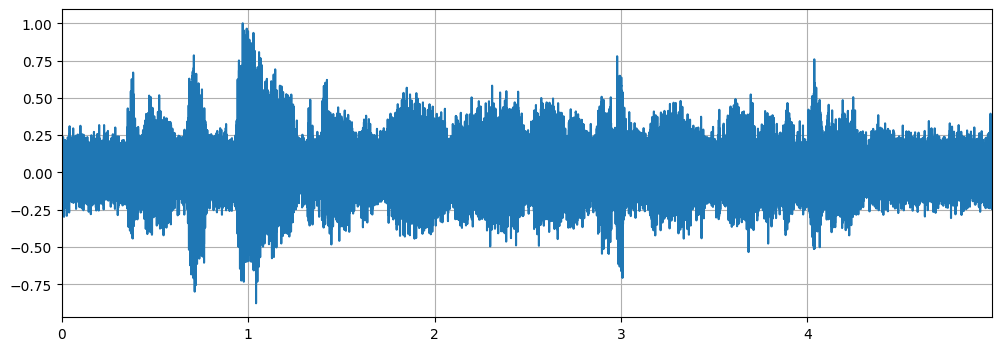

In [20]:
fs, data = wavfile.read("speech_w_noise.wav")
xn = data/max(abs(data))

plt.close(1); plt.figure(1, figsize=(12,4))
plt.plot(np.linspace(0, len(xn)/fs, len(xn), endpoint=False), xn)
plt.grid(True)
plt.xlim([0, len(xn)/fs])

noiseStart = int(0.3 * fs)  
noiseEnd = int(1.5 * fs)
xn = xn[noiseStart:noiseEnd]

print(f"{fs =}")
print(xn)

Audio(xn, rate=fs)


## a)

Study the audio envelope in the above figure. Use slicing to select one signal segment containing only noise, and one signal segment dominated by speech (the longer the better). If in doubt, try listening to the segments to see if they have the desired content.

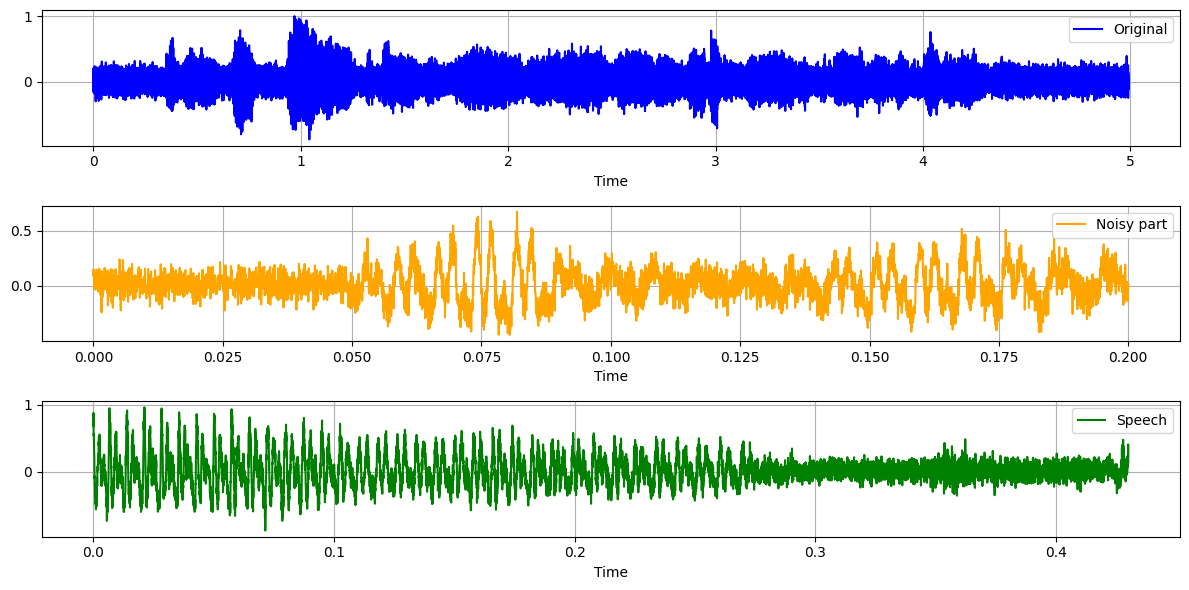

In [22]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  

noiseSeg = xn[int(0.3 * fs): int(0.5 * fs)]
   
speechSeg = xn[int(0.97*fs):int(1.4*fs)]


plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, len(xn) / fs, len(xn), endpoint=False), xn, color='blue', label='Original')
plt.xlabel("Time")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.linspace(0,(int(0.5 * fs)-int(0.3 * fs))/fs, (int(0.5 * fs)-int(0.3 * fs))), noiseSeg, color='orange', label='Noisy part')
plt.xlabel("Time")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.linspace(0, (int(1.4*fs) - int(0.97*fs)) / fs, int(1.4*fs) - int(0.97*fs)), speechSeg, color='green', label='Speech')
plt.xlabel("Time")
plt.grid(True)


plt.legend()
plt.tight_layout()
plt.show()




## b) 
Choose a number of filter taps which you think sounds promising (e.g. $M=128$), and use function [welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html) to estimate the power spectral density `S_xx` and `S_vv` of both segments from part **a)** with resolution $M$ (`nfft=M`). Then, calculate the frequency response $H_v(\hat{\omega})=\frac{S_{vv}(\hat{\omega})}{S_{xx}(\hat{\omega})}$ and show the magnitude response curve in a plot.

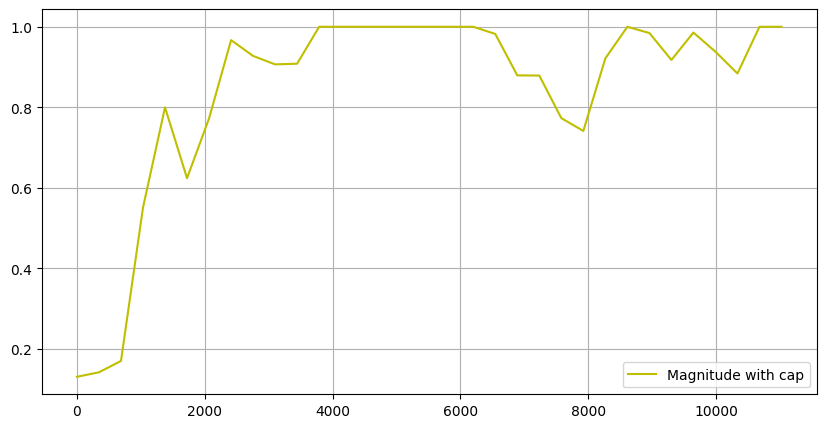

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch


fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  
noiseStart = int(0.5 * fs)  
noiseEnd = int(1.5 * fs)
noiseSeg = xn[noiseStart:noiseEnd]

speechStart = int(3.0 * fs)
speechEnd = int(4.5 * fs)
speechSeg = xn[speechStart:speechEnd]

h_len = 64

f_xx, S_xx = welch(speechSeg, fs=fs, nperseg=h_len, nfft=h_len)  
f_vv, S_vv = welch(noiseSeg, fs=fs, nperseg=h_len, nfft=h_len)  


#The frequency response
H_v = S_xx / S_vv

#capping
cappedSig = np.minimum(H_v, 1)

plt.figure(figsize=(10, 5))
plt.plot(f_xx, np.abs(cappedSig), color='y', label=r"Magnitude with cap")
plt.grid(True)
plt.legend()
plt.show()



[Here](figures/task4b_lf.png) is an example of what the noise enhancing filter's magnitude response might look like. Here, i have set an upper limit for filter gain at $1$.

## c) 
Calculate the frequency response of the complimentary filter  $H_s(\hat{\omega}) = 1 - H_v(\hat{\omega})$. The array of $M$ values representing $H_s(\hat{\omega})$ can soon be transformed back to the time domain to acquire an impulse response $h[n]$, but there is a final adjustment we need to make first: 
>Seeing as our filter is supposed to be causal, it is practically impossible for the filter to have a phase response $\angle H_s(\hat{\omega}) = 0$, but this is basically what our current frequency response attempts to do. To account for this, we must add $D=\frac{M-1}{2}$ samples of delay to ensure symmetry properties of the impulse response $h_s[n]$. This is done by *in the frequency domain* adjusting the angle of the frequency response accordingly:
>
>$$H_s(\hat{\omega}) \cdot e^{-j\hat{\omega}D}$$
>
>PS: Using this method it is perfectly possible to impose a fractional delay (e.g. $63.5$ samples)

Once you have your phase adjusted frequency response, an impulse response with somewhat suitable frequency-domain properties may be found using `irfft`. What we are doing is often referred to as the frequency sampling filter design method, and is explained thoroughly in chapter 7.4. 

Verify your work by creating a figure showing both a high-resolution magnitude response $|H_s(\hat{\omega})|$ of the filter, as well as the impulse response $h[n]$.

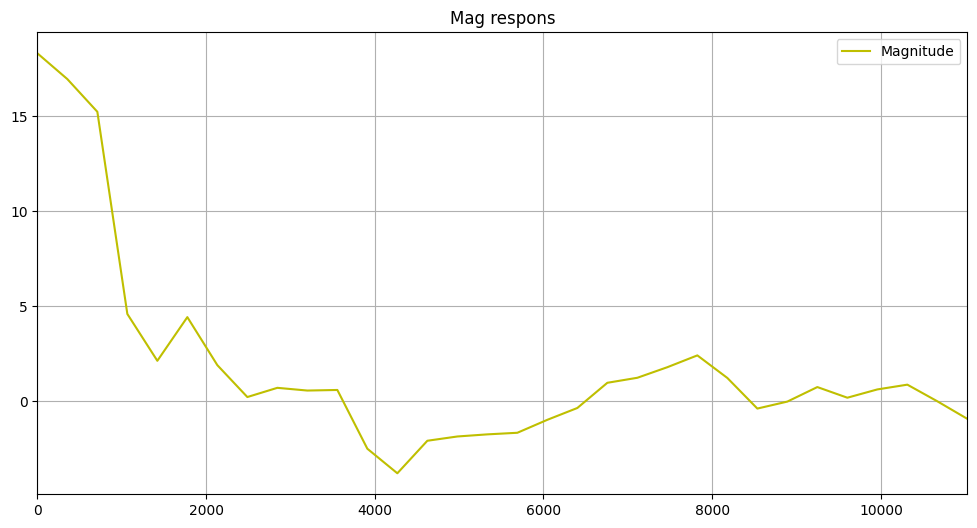

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch, windows
from scipy.fft import irfft, rfftfreq

fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  
h_len = 62

#
f_filt, P_xx = welch(speechSeg, fs=fs, nperseg=h_len, noverlap=h_len//2)  
_, P_vv = welch(noiseSeg, fs=fs, nperseg=h_len, noverlap=h_len//2)  

noise_floor = np.median(P_vv)  



#more 
#filter_constant = 7
#P_xx = np.where(P_xx < noise_floor*filter_constant, P_xx, noise_floor)
#P_vv = np.where(P_vv < noise_floor*filter_constant, P_vv, noise_floor)


#subtracting noise
P_ss = P_xx - P_vv


#frequency response
h_filt = P_ss / (P_ss + P_vv)
#capping
H_v_capped = np.minimum(h_filt, 1)
H_s = 1 - H_v_capped #complementary

D = (h_len - 1) / 2  
frequencies = rfftfreq(h_len, 1/fs)  


#plt.figure(figsize=(10, 5))
#plt.plot(f_filt, 10 * np.log10(P_ss)")
#plt.ylabel("Mag")
#plt.grid(True)
#plt.legend()
#plt.show()



H_s_phase_adjusted = H_s * np.exp(-1j * 2 * np.pi * frequencies * D)




#frequencyThresh = 50
#H_s_phase_adjusted[abs(frequencies) > frequencyThresh] = 0

h_s = irfft(H_s_phase_adjusted, n=h_len)
h_s_windowed = h_s * windows.hamming(h_len)

plt.figure(figsize=(12, 6))

filteredSig = np.convolve(xn, h_s_windowed, mode='same')
filteredSig = filteredSig / max(abs(filteredSig))


plt.subplot(1, 1, 1)

plt.plot(f_filt, 20 * np.log10(np.abs(H_s)), label=r"Magnitude", color = "y")
plt.xlim([0, fs / 2])
plt.title("Mag respons")
plt.grid(True)
plt.legend()




[Here](figures/task4c_lf.png) is an example of what the speech enhancing filter's magnitude response might look like.

## d) 

Use the filter you calculated in **c)** to filter the signal $x[n]$, and listen to the result. Do not expect crystal clear audio, this noise filtering technique has a lot of potential for improvement. However, there should absolutely be a noticeable reduction in noise level. 

Finally, plot the envelope of the filtered audio signal alongside the original, and comment on the difference between the two.

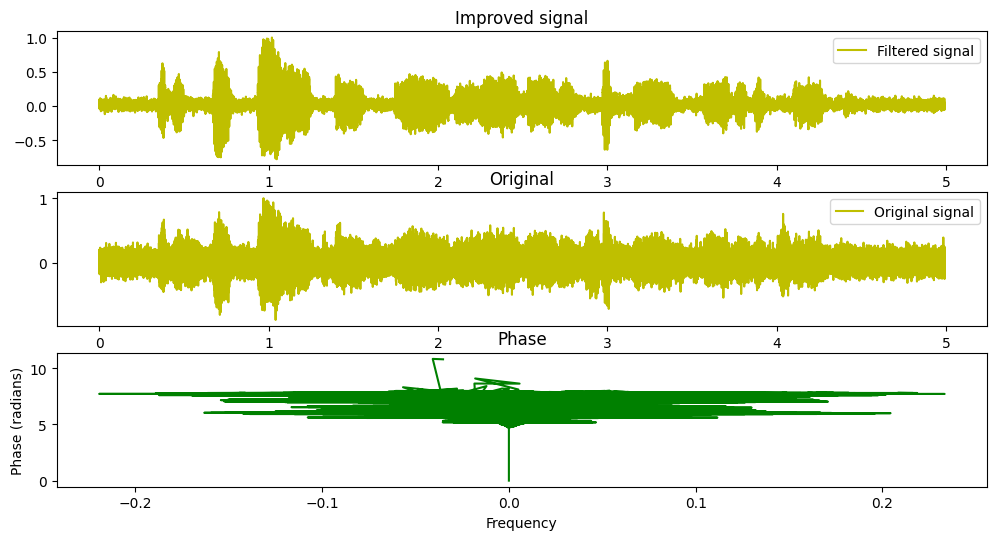

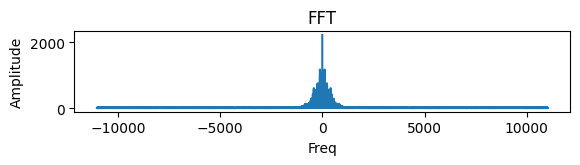

<Figure size 640x480 with 0 Axes>

In [19]:
# WRITE YOUR CODE IN THIS CELL:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(np.linspace(0, len(filteredSig)/fs, len(filteredSig), endpoint=False), filteredSig, label="Filtered signal", color="y")
plt.title("Improved signal")
plt.legend()



plt.subplot(4, 1, 2)
plt.plot(np.linspace(0, len(xn)/fs, len(xn), endpoint=False), xn, label="Original signal", color="y")
plt.title("Original")
plt.xlabel("Time")
plt.legend()

#https://www.geeksforgeeks.org/plot-the-phase-spectrum-in-python-using-matplotlib/

plt.subplot(4, 1, 3)
plt.phase_spectrum(np.linspace(0, len(filteredSig)/fs, len(filteredSig), endpoint=False), filteredSig, color ='green') 
plt.title("Phase") 
plt.show() 


#https://www.geeksforgeeks.org/spectrum-analysis-in-python/

t = np.linspace(0, len(filteredSig)/fs, len(filteredSig), endpoint= False) 
fft_result = np.fft.fft(filteredSig)
freq = np.fft.fftfreq(t.shape[-1], d=1/fs)


plt.subplot(4, 1, 4)

plt.plot(freq, np.abs(fft_result))
plt.title('FFT')
plt.xlabel('Freq')
plt.ylabel('Amplitude')
plt.show()

plt.tight_layout()
plt.show()


Audio(filteredSig, rate=fs)
